In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora

import matplotlib.pyplot as plt
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import string 

# Read Data

In [2]:
os.chdir(r'C:\BA Capstone')
data = pd.read_csv('final.csv')
print(data.shape)
print('\n')
print(data.columns)
print('\n')
print(data.info())
data.head()

(42518, 23)


Index(['Unnamed: 0', 'User', 'Tweet_id', 'Timestamp', 'Message', 'Hashtags',
       'Replies', 'Retweets', 'Likes', 'Location', 'State', 'City',
       'is_duplicated', 'Sentiment_list', 'Sentiment', 'Score', 'Phrase',
       'Emotion_list', 'Emotion', 'Emotion_score', 'Company', 'Category',
       'clean_message'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42518 entries, 0 to 42517
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      42518 non-null  int64  
 1   User            42518 non-null  object 
 2   Tweet_id        42518 non-null  object 
 3   Timestamp       42501 non-null  object 
 4   Message         42518 non-null  object 
 5   Hashtags        33567 non-null  object 
 6   Replies         6026 non-null   object 
 7   Retweets        7830 non-null   object 
 8   Likes           9872 non-null   object 
 9   Location        34681 non-null  obj

c:\Users\Rohitha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,User,Tweet_id,Timestamp,Message,Hashtags,Replies,Retweets,Likes,Location,...,Sentiment_list,Sentiment,Score,Phrase,Emotion_list,Emotion,Emotion_score,Company,Category,clean_message
0,0,@beautybiting,1.04E+18,8/31/2018 12:17,expanding my market into wisconsin i am now li...,#letspartner #letsnetwork #lovetheduck #Aflac ...,NaN,NaN,NaN,NaN,...,"['Neutral', 0.9894123673439026]",Neutral,0.989412367,"['my market', 'Wisconsin', 'Illinois and Wisco...","['joy', 0.37409132719039917]",joy,0.374091,Aflac,Brand,expand market wisconsin license illinois wisco...
1,1,@melonhead1822,1.04E+18,8/31/2018 3:54,i ve watched aflac screw my co workers for mon...,#Aflac #Aflac #donttrust #wasteofmoney #scam,1.0,NaN,NaN,Holden,...,"['Negative', 0.7589784860610962]",Negative,0.758978486,"['Aflac', 'my co workers', 'months', 'my turn ...","['sadness', 0.5176457762718201]",sadness,0.517646,Aflac,Brand,watch aflac screw worker month guess turn clai...
2,2,@AfLIACon,1.04E+18,8/30/2018 19:57,alert aflia will be bringing down the curtains...,#AfLIA #AfLAc,NaN,8,9,"Accra, Ghana",...,"['Neutral', 0.9936059713363647]",Neutral,0.9936059709999999,"['ALERT AfLIA', 'the curtains', 'AfLAc applica...","['fear', 0.8599311709403992]",fear,0.859931,Aflac,Brand,alert aflia bringing curtain aflac application...
3,3,@HadleeHarris1,1.03E+18,8/29/2018 21:45,except they never pay the customers claims wor...,#NeverAFLAC #AFLAC #AFLACSucks,NaN,NaN,NaN,United States,...,"['Negative', 0.8842974901199341]",Negative,0.88429749,"['the customers', 'Worst company', 'No ethics'...","['sadness', 0.49600017070770264]",sadness,0.496000,Aflac,Brand,except never customer claim worst company ever...
4,4,@HadleeHarris1,1.04E+18,8/29/2018 21:40,just saw ad saying you pay in 1 day biggest li...,#AFLACSUCKS #NeverBuyAFLAC #AFLAC,1.0,NaN,NaN,United States,...,"['Negative', 0.9010137319564819]",Negative,0.901013732,"['ad', '1 day', 'Biggest lie EVER', 'thieves',...","['sadness', 0.537878155708313]",sadness,0.537878,Aflac,Brand,saying big ever never thief robber read review...


In [3]:
data.columns

Index(['Unnamed: 0', 'User', 'Tweet_id', 'Timestamp', 'Message', 'Hashtags',
       'Replies', 'Retweets', 'Likes', 'Location', 'State', 'City',
       'is_duplicated', 'Sentiment_list', 'Sentiment', 'Score', 'Phrase',
       'Emotion_list', 'Emotion', 'Emotion_score', 'Company', 'Category',
       'clean_message'],
      dtype='object')

In [5]:
data.Company.value_counts()

Aflac            26950
Cigna            10630
Allstate          4851
Colonial Life       86
Company              1
Name: Company, dtype: int64

# Defining Functions For Topic Modeling

In [6]:
# Lemmatiztion
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# Get stopwords
stop_words = set(stopwords.words('english')) 
stop_list = list(stop_words)
stop_list.append('aflac')

def remove_special_char(text):
    '''
    Utility function to clean text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)", " ", str(text)).split())

def pos_tags(text):
    tokens = word_tokenize(text)
    return ' '.join([word for (word, pos) in nltk.pos_tag(tokens) if pos[:2] in ['NN','JJ','RB','VB']])

#function to  Clean the tweet
def clean(text):
    clean_txt = remove_special_char(text)
    postags = pos_tags(clean_txt)
    tokens = word_tokenize(postags)
    tokens_lower = [token.lower() for token in tokens if len(token) > 3]
    tokens_stop = [token for token in tokens_lower if token not in stop_list]
    tokens_clean = [get_lemma(token) for token in tokens_stop]
    return ' '.join(tokens_clean)

In [7]:
def clean_token(dframe,company):
    df = dframe[(data['Company'] == company) & (dframe['Sentiment'] == 'Negative')]
    negative_tweets = []
    df.reset_index(inplace=True)
    for i in range(df.shape[0]):
         negative_tweets.append(df['Message'][i])
    
    clean_tweets = []
    for c in negative_tweets:
        cleaned = clean(c)
        clean_tweets.append(cleaned)
        
    clean_tokens = []
    for c in clean_tweets:
        tokens = word_tokenize(c)
        clean_tokens.append(tokens)
    return clean_tokens

In [8]:
def final_tokens(dframe,company,remove):
    company_tokens = clean_token(dframe,company)
    company_tokens_new = []
    for i in company_tokens:
        company_tokens_new.append([token for token in i if token not in remove])
    return company_tokens_new

In [9]:
def clean_tweet(dframe,company):
    df = dframe[(data['Company'] == company) & (dframe['Sentiment'] == 'Negative')]
    negative_tweets = []
    df.reset_index(inplace=True)
    for i in range(df.shape[0]):
         negative_tweets.append(df['Message'][i])
    
    clean_tweets = []
    for c in negative_tweets:
        print(c)
        cleaned = clean(c)
        clean_tweets.append(cleaned)
    return clean_tweets

In [10]:
def make_bigrams(texts,model):
    return [model[doc] for doc in texts]

In [11]:
def get_topics(text,topics):
    # Create Dictionary
    bigram = gensim.models.Phrases(text, min_count=1, threshold=10)# higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    comments_with_bigrams = make_bigrams(text,bigram_mod)

    id2word = corpora.Dictionary(comments_with_bigrams)

# Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in comments_with_bigrams]

# Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

    #fiz=plt.figure(figsize=(15,30))
    for i in range(topics):
        df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
        #print("Topic {}: {}".format(i+1, ' '.join(df.index.values)))
        #print('Topic '+str(i+1)+': ',df.index)
        #df=df.sort_values('prob')
    
        #plt.subplot(5,2,i+1)
        #plt.title('topic '+str(i+1))
        #sns.barplot(x='prob', y=df.index, data=df,palette='Reds_d')
        #plt.xlabel('probability')
    
    #plt.show()

# Defining Function For Wordcloud

In [12]:
from wordcloud import WordCloud
def create_cloud(dframe,company):
    clean_twt = clean_tweet(dframe,company)
    text = " ".join(txt for txt in clean_twt)
    words = []
    tokens = nltk.tokenize.word_tokenize(text)
    fd = nltk.FreqDist(tokens)
    for word, frequency in fd.most_common(100):
        words.append(word)
    print(words)
    wc = WordCloud( max_words=100,background_color="white").generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Topic Modeling

# Aflac

i ve watched aflac screw my co workers for months and now i guess it s my turn claim denied cause it was before policy start date it was last saturday and i ve had aflac for 3 years donttrust wasteofmoney scam
except they never pay the customers claims worst company ever no ethics no morals just greedy lying pigs neveraflac aflac aflacsucks
just saw ad saying you pay in 1 day biggest lie ever you never pay you are thieves and robbers just read 653 bad reviews snail mail and fax only assholes aflacsucks neverbuyaflac aflac
how can these people in these commercials possibly forget aflac is an option when this annoying duck is popping up nonstop giving unsolicited solutions to words it misunderstands
that aflac duck is a little too disappointed when he finds out people aren t sick and injured aflac theduckdidit
they don t care policies are extremely high most seniors in my area will not touch them paperwork is a nightmare bills get left unpaid unless you argue forever we prefer aflac you 

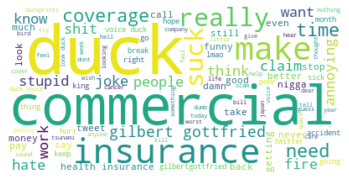

In [13]:
create_cloud(data,'Aflac')

In [14]:
remove = ['aflac','japan','duck','gilbert gottfried','gilbertgottfried','quack','duckprints','nigga','gilbert_gottfried','gilbert','gottfried']
aflac_final_tokens = final_tokens(data,'Aflac',remove)
get_topics(aflac_final_tokens,10)

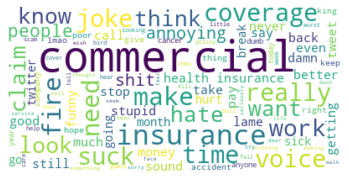

In [15]:
# WORD CLOUD AFTER REMOVING THE REDUNDANT WORDS
aflac_list = []
for l in aflac_final_tokens:
    aflac_list.extend(l)
text_aflac = " ".join(txt for txt in aflac_list) 
wc_aflac = WordCloud( max_words=100,background_color="white").generate(text_aflac)
plt.imshow(wc_aflac, interpolation='bilinear')
plt.axis("off")
plt.show()

# Cigna

cigna your scam calls are annoying af stop calling
received yet another unsatisfactory response from one of you reinstating my belief that this is one of the most unreliable entities to be associated with you have lost a customer now and gained a proponent of negative word of mouth for cigna
here we go again another denial of claims by cigna my husband never ever goes to a dr he had a spot on his nose head that needed to be looked at aren t we suppose to do preventative care cigna had denied more claims than they ve paid do not waste your money on cigna pic twitter com qhxk98kq4q
cigna you suck
women be aware of they are crooks will charge you for almost 5000 in medications never received tell you there is nothing they can do criminal activity theft they need to investigated immediately cigna cignapharmacy grandtheft
davidmcordani cigna f**kcigna it s f**king disgusting this motherf**king asshole gets this compensation while my friend gets sent home from immunotherapy with tumors on he

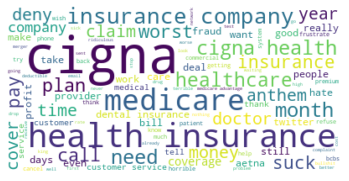

In [16]:
create_cloud(data,'Cigna')

In [17]:
remove = ['need','go','get','cigna','stop','ever','bcbs','make','tell','try','know','back','also']
cigna_final_tokens = final_tokens(data,'Cigna',remove)
get_topics(cigna_final_tokens,10)

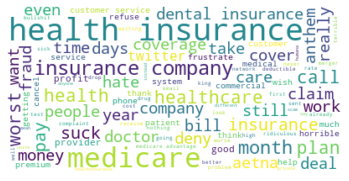

In [18]:
# WORD CLOUD AFTER REMOVING THE REDUNDANT WORDS
cigna_list = []
for l in cigna_final_tokens:
    cigna_list.extend(l)
text_cigna = " ".join(txt for txt in cigna_list) 
wc_cigna = WordCloud( max_words=100,background_color="white").generate(text_cigna)
plt.imshow(wc_cigna, interpolation='bilinear')
plt.axis("off")
plt.show()

# Allstate 

double charged me for my car insurance admitted it was their mistake because they gave me incorrect instructions and won t fix it then the person on live chat told me they can t do anything because they re just a contact center this is absurd
sorry never getting your shit
just spent almost 2 months getting an insurance quote from i had a 10 10 driving score and their cheapest quote was 81 more than and 86 more than not impressed
aye f**k y all
so why does your site limit passwords to a maximum of ten characters longer passwords are more secure and enforcing a max length like that implies other password management bad practices please fix this security passwordspic twitter com iffau8r5us
how does any brand still advertise on this network if you are or or or why would you place ads on a network where you could at any time show up just after someone says something disgusting like this it s unreal
we are not in good hands our adjuster rejects our damages as not relevant to the fire we had 

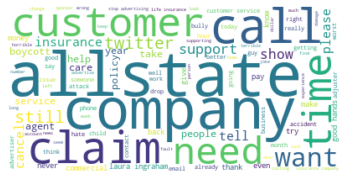

In [19]:
create_cloud(data,'Allstate')

In [20]:
remove = ['allstate','call','need','still','want','please','laura','ingraham','help','know','say','never','getting','drop','today',
         'ever','guy','right','thanks','seem','pull']
allstate_final_tokens = final_tokens(data,'Allstate',remove)
get_topics(allstate_final_tokens,10)

# Colonial Life

when is about to cancel his life insurance but u been loyal to his stupid ass for 10 years
dear how many times to i have to opt out of your emails i would rather juggle chainsaws than sell life insurance so f**k off
['life', 'insurance', 'cancel', 'loyal', 'stupid', 'years', 'dear', 'many', 'times', 'email', 'rather', 'juggle', 'chainsaw', 'sell']


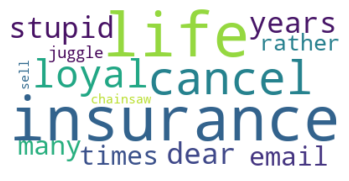

In [21]:
create_cloud(data,'Colonial Life')

In [22]:
remove = ['many','rather']
colonial_final_tokens = final_tokens(data,'Colonial Life',remove)
get_topics(colonial_final_tokens,5)

In [23]:
data.Company.value_counts()

Aflac            26950
Cigna            10630
Allstate          4851
Colonial Life       86
Company              1
Name: Company, dtype: int64

# Topic Modeling for Met Life

In [24]:
# lOAD THE DATA
metlife = pd.read_csv('metlife_final.csv')
print(metlife.shape)
print(metlife.columns)
metlife.head()


(18843, 22)
Index(['Unnamed: 0', 'User', 'Tweet_id', 'Timestamp', 'Message', 'Hashtags',
       'Replies', 'Retweets', 'Likes', 'Location', 'State', 'City',
       'is_duplicated', 'Sentiment_list', 'Sentiment', 'Score', 'Phrase',
       'Emotion_list', 'Emotion', 'Emotion_score', 'Company', 'Category'],
      dtype='object')


,Unnamed: 0,User,Tweet_id,Timestamp,Message,Hashtags,Replies,Retweets,Likes,Location,...,is_duplicated,Sentiment_list,Sentiment,Score,Phrase,Emotion_list,Emotion,Emotion_score,Company,Category
0,0,@GiovanniFrancoA,1.05E+18,9/28/2018 16:57,metlife ironman 70 3 cozumel 2018 presentado p...,NaN,NaN,NaN,2,"Oaxaca, México.",...,False,"['Neutral', 0.9816178679466248]",Neutral,0.981618,['MetLife Ironman 70 3 Cozumel 2018 presentado...,"['joy', 0.7094311714172363]",joy,0.709431,MetLife,Brand
1,1,@MetAlbayrak,1.05E+18,9/28/2018 16:00,vallahi bu d nemi nas l atlat r m bilmiyorum b...,NaN,NaN,NaN,7,"Eski?ehir, Türkiye",...,False,"['Neutral', 0.7810289859771729]",Neutral,0.781029,['Vallahi bu d nemi nas l atlat r m bilmiyorum...,"['sadness', 0.29014238715171814]",sadness,0.290142,MetLife,Brand
2,2,@happilylarry_x,1.05E+18,9/28/2018 15:58,metlife 2014 pic twitter com efloa1ys4w,NaN,1,NaN,2,?LARRY FBI™??,...,False,"['Neutral', 0.9801350235939026]",Neutral,0.980135,['MetLife 2014 pic twitter com eFloA1yS4'],"['joy', 0.2850568890571594]",joy,0.285057,MetLife,Brand
3,3,@Tregroovy,1.05E+18,9/28/2018 15:55,what s funny is pulled up to metlife bumping t...,NaN,NaN,NaN,NaN,BULLY UP NYG,...,False,"['Negative', 0.7833356261253357]",Negative,0.783336,['metlife'],"['anger', 0.46428608894348145]",anger,0.464286,MetLife,Brand
4,4,@HoyenCozumel,1.05E+18,9/28/2018 15:37,isladeldeporte metlife ironman 70 3 lo mejor d...,#IsladelDeporte #IronMan #IslaCozumel #BastaDe...,NaN,NaN,NaN,NaN,...,False,"['Neutral', 0.9842604994773865]",Neutral,0.984260,['IsladelDeporte MetLife IronMan 70 3 Lo mejor...,"['surprise', 0.46396785974502563]",surprise,0.463968,MetLife,Brand


In [25]:
df = metlife[metlife['Sentiment'] == 'Negative']
negative_tweets = []
df.reset_index(inplace=True)
for i in range(df.shape[0]):
    negative_tweets.append(df['Message'][i])
    
clean_tweets = []
for c in negative_tweets:
    cleaned = clean(c)
    clean_tweets.append(cleaned)
        
clean_tokens = []
for c in clean_tweets:
    tokens = word_tokenize(c)
    clean_tokens.append(tokens)

['metlife', 'show', 'night', 'insurance', 'company', 'going', 'still', 'time', 'call', 'even', 'need', 'twitter', 'game', 'want', 'customer', 'king', 'look', 'policy', 'make', 'people', 'really', 'know', 'literally', 'try', 'go', 'taylor', 'never', 'service', 'think', 'give', 'worst', 'take', 'getting', 'play', 'shit', 'cancel', 'week', 'phone', 'please', 'right', 'last', 'back', 'help', 'years', 'rain', 'giant', 'jet', 'claim', 'jersey', 'come', 'someone', 'also', 'say', 'sorry', 'work', 'month', 'first', 'better', 'life', 'miss', 'support', 'hate', 'today', 'good', 'business', 'year', 'tweet', 'pay', 'otra', 'nothing', 'home', 'team', 'stop', 'everyone', 'much', 'long', 'suck', 'already', 'piss', 'start', 'email', 'pitch', 'tell', 'ever', 'cant', 'money', 'website', 'days', 'next', 'number', 'guy', 'enough', 'guest', 'hard', 'lose', 'keep', 'care', 'hope', 'happen', 'auto']


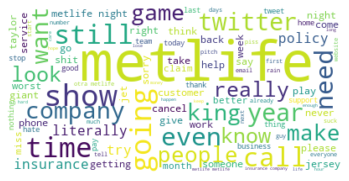

In [26]:
text = " ".join(txt for txt in clean_tweets)
words = []
tokens = nltk.tokenize.word_tokenize(text)
fd = nltk.FreqDist(tokens)
for word, frequency in fd.most_common(100):
    words.append(word)
print(words)
wc = WordCloud( max_words=100,background_color="white").generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
remove = ['metlife','show','want','still','even','need','really','know','try','go','think','give','take','please','phone','last',
         'back','also','say','otra','stop','much','long','next','start','tell','ever','cant']
tokens_new = []
for i in clean_tokens:
    tokens_new.append([token for token in i if token not in remove])
get_topics(tokens_new,10)

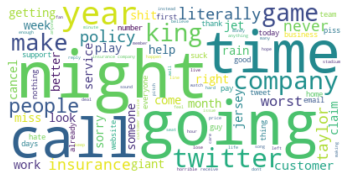

In [28]:
metlife_list = []
for l in tokens_new:
    metlife_list.extend(l)
text_metlife = " ".join(txt for txt in metlife_list) 
wc_metlife = WordCloud( max_words=100,background_color="white").generate(text_metlife)
plt.imshow(wc_metlife, interpolation='bilinear')
plt.axis("off")
plt.show()